# Scenario analysis

## Set up environment

In [1]:
# Constants used throughout the file
SCENARIOS = [
    "BASELINE",
    "SCN_BASE",
    "SCN_MIN_LEY",
    #"SCN_REDUCED_MILK",
    "SCN_SNG",
    "SCN_ORG",
]

PROTEIN_CONTENTS = {
    "Peas (add)": 220,
    "Wheat (add)": 67.15,
    "meat": 155.5,
    "milk": 35.0,
}

In [2]:
CM_BASEPATH = '../cibusmod'

import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), CM_BASEPATH))

import CIBUSmod as cm
import CIBUSmod.utils.plot as plot

import time
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import PercentFormatter

from CIBUSmod.utils.misc import inv_dict, aggregate_data_coords_pair
from CIBUSmod.optimisation.indexed_matrix import IndexedMatrix
from CIBUSmod.optimisation.utils import make_cvxpy_constraint
from itertools import product

In [3]:
# Create session
session = cm.Session(
    name = 'main',
    data_path = "data",
    data_path_default = CM_BASEPATH + "/data/default",
)
session

,calculated
year,
2020,2025-01-17 11:15:26
,calculated
year,
2020,2025-01-17 11:28:57
,calculated
year,
2020,2025-01-17 11:45:21
,calculated
year,


## Land use

### Was all land used?

In [4]:
max_lu = session.get_attr('r', 'max_land_use').droplevel("year")
scn_lu = session.get_attr('c', 'area', { "region": None, "crop": "land_use" }).droplevel("year")
share_lu = (scn_lu / max_lu).replace({np.inf: 1, np.nan: 1})

In [5]:
with pd.option_context('display.max_columns', None):
    display(share_lu.T.xs("cropland", level="land_use").T)

region,1011,111,1111,1112,112,1121,1122,1123,1124,1131,1211,1212,1213,1214,1215,1216,1221,1222,1311,1321,1322,1331,1411,1412,1421,1511,1512,1521,1522,1611,1612,1613,1614,1615,1616,1617,1621,1622,1623,1711,1712,1713,1721,1722,1723,1724,1811,1812,1813,1821,1911,1912,1921,1922,2011,2012,2019,2111,2121,2122,2211,2212,2221,2311,2312,2319,2331,2411,2412,2413,2414,2415,2419,2511,2512,2519,2521,311,312,321,322,411,421,422,431,511,512,513,514,515,521,611,612,621,622,711,731,811,812,813,814,821,831,911,912,913
scn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BASELINE,1.0,1.0,0.999753,0.996737,1.0,1.0,0.986073,0.998148,0.970294,0.985877,0.963427,0.96255,0.963735,0.977571,1.0,0.975226,0.971864,1.0,0.994247,1.0,0.990679,0.976249,0.971665,0.980336,0.983928,0.998056,0.982185,0.994978,0.965762,0.987712,1.0,0.976223,0.991054,0.992066,0.982032,0.980797,0.990909,0.98356,0.977658,1.0,0.990131,1.0,0.978144,1.0,0.994224,0.981001,1.0,0.995903,0.987868,0.983997,0.981477,0.985461,0.991007,0.982029,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.991441,0.980759,0.994823,0.96817,0.985457,0.977874,0.987736,0.982299,0.989726,0.982775,0.987514,0.993496,0.976664,0.96475,0.975389,0.98403,0.984917,0.984241,0.988973,1.0,0.995274,1.0,1.0,0.995079,0.966346,1.0,0.993645,1.0,1.0
SCN_BASE,1.0,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.0
SCN_MIN_LEY,1.0,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.0
SCN_SNG,1.0,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.0
SCN_ORG,1.0,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.0,1

### Land use

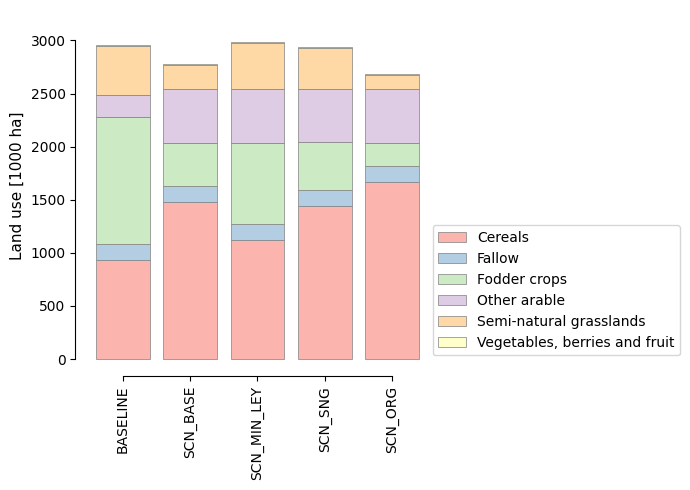

In [6]:
fig, ax = plt.subplots(figsize=(7,5))

factor = 1000
landuse_data = (
    (session.get_attr('C','area',groupby={'crop':'crop_group2'})/factor)
    .drop(['Greenhouse crops'], axis=1)
    .droplevel('year')
)
plot.bar(
    data=landuse_data,
    ax=ax,
    cmap='Pastel1',
    edgecolor='grey'
)

ax.tick_params(axis='y', which='major')
ax.set_xlabel('')
ax.set_ylabel(f'Land use [{factor} ha]')
ax.set_ylim(top=landuse_data.sum(axis=1).max()*1.1)
ax.legend(loc='lower left', bbox_to_anchor=(1, 0))
fig.tight_layout()

fig.savefig("figures/land-use.pdf")

fig.show()

## Distribution of Semi-natural grasslands

crop,Semi-natural meadows,Semi-natural pastures,"Semi-natural pastures, thin soils","Semi-natural pastures, wooded"
scn,,,,
BASELINE,9849.208051,373918.341247,58488.146614,12733.130584
SCN_BASE,11997.132000,172919.583311,36334.861498,7345.636732
SCN_MIN_LEY,11997.132000,350309.881034,59437.889267,12944.851179
SCN_SNG,11997.132000,367034.014423,5308.581418,2200.226808
SCN_ORG,11997.125178,82200.362819,30414.174245,4844.093696


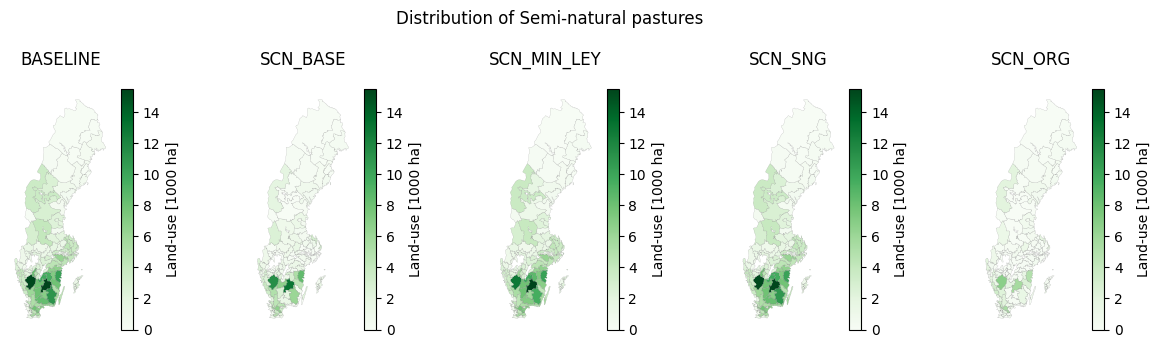

In [7]:
sng_lu = session.get_attr("C","area", ["region", "crop"]).droplevel("year").T.xs("Semi-natural pastures", level="crop").T
# Or, all SNG types:
# sng_lu = session.get_attr("C","area",{"crop": "land_use", "region": None}).droplevel("year").T.xs("semi-natural grasslands", level="land_use").T

scenarios = SCENARIOS
n_scn = len(scenarios)

sng_lu = sng_lu / 1e3
vmin = 0
vmax = sng_lu.max().max()
fig, axs = plt.subplots(1, n_scn, figsize=(n_scn * 2.5, 3.5))
for scn, ax in zip(scenarios, axs):
    ax.set_title(scn)
    ax.set_axis_off()
    
    plot.map_from_series(
        sng_lu.loc[scn], ax=ax, 
        vmin=vmin, vmax=vmax,
        edgecolor="grey",
        cmap='Greens', legend_kwds={"label": f"Land-use [1000 ha]"},
    )
    
fig.suptitle("Distribution of Semi-natural pastures")
fig.tight_layout()
fig.savefig("figures/sng-distribution.png")

session.get_attr("C","area",{"crop": [None, "land_use"]}).droplevel("year").T.xs("semi-natural grasslands", level="land_use").T

### Change in SNG and cropland

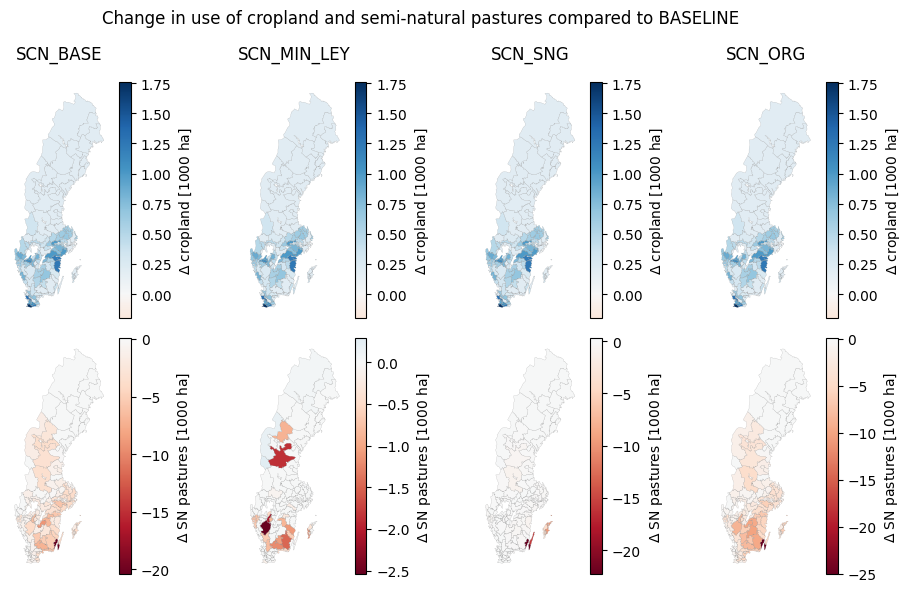

In [8]:
land_use = session.get_attr('C','area',{'crop': 'land_use', 'region':None}).droplevel("year")
land_use = (land_use - land_use.loc['BASELINE'])

scenarios = [scn for scn in land_use.index.unique("scn") if scn != "BASELINE"]
n_scn = len(scenarios)
fig, axs2d = plt.subplots(2, n_scn, figsize=(n_scn * 2.5, 6))

for scn, axs in zip(scenarios, axs2d.T):
    axs[0].set_title(scn)
    for ax, land_type in zip(axs, ["cropland", "semi-natural grasslands"]):
        data = land_use.loc[scn,:].xs(land_type, level="land_use") / 1e3
        lim = abs(data).quantile(0.99)
        ax.set_axis_off()
        lt = "SN pastures" if land_type == "semi-natural grasslands" else land_type
        plot.map_from_series(
            data, ax=ax, 
            cmap='RdBu', edgecolor='grey', 
            legend_kwds={'label': fr'$\Delta$ {lt} [1000 ha]'},
            cmap_zero_midpoint="shrink"
        )

fig.suptitle("Change in use of cropland and semi-natural pastures compared to BASELINE")
fig.tight_layout()
fig.show()

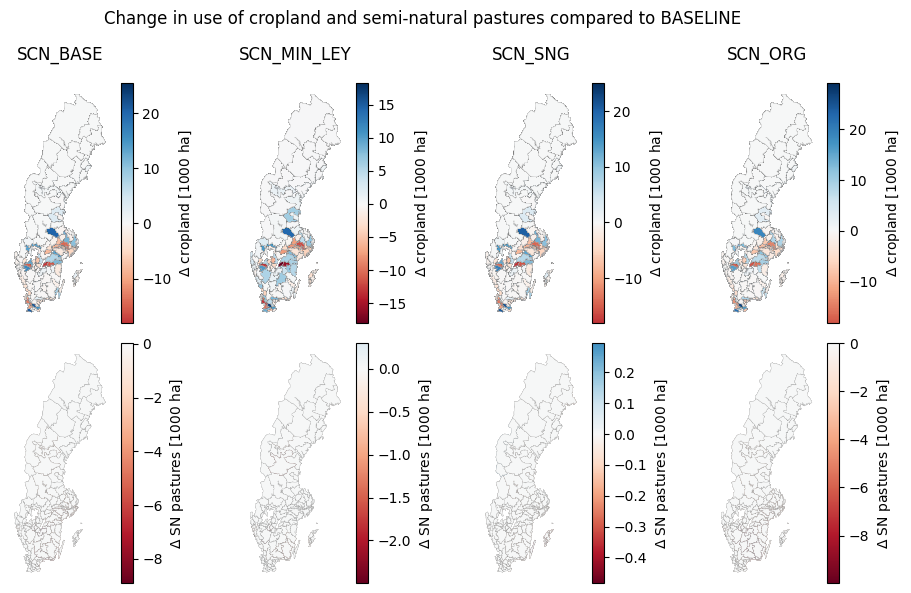

In [9]:
land_use = session.get_attr('C','area',{'crop': [None, 'land_use'], 'region':None}).droplevel("year")
# Drop non-pasture SNGs
land_use.loc[:,["Semi-natural meadows", "Semi-natural pastures, thin soils", "Semi-natural pastures, wooded"]] = 0
land_use = land_use.droplevel("crop", axis=1)

land_use = (land_use - land_use.loc['BASELINE'])

scenarios = [scn for scn in land_use.index.unique("scn") if scn != "BASELINE"]
n_scn = len(scenarios)
fig, axs2d = plt.subplots(2, n_scn, figsize=(n_scn * 2.5, 6))

for scn, axs in zip(scenarios, axs2d.T):
    axs[0].set_title(scn)
    for ax, land_type in zip(axs, ["cropland", "semi-natural grasslands"]):
        data = land_use.loc[scn,:].xs(land_type, level="land_use") / 1e3
        lim = abs(data).quantile(0.99)
        ax.set_axis_off()
        lt = "SN pastures" if land_type == "semi-natural grasslands" else land_type
        plot.map_from_series(
            data, ax=ax, 
            cmap='RdBu', edgecolor='grey', 
            legend_kwds={'label': fr'$\Delta$ {lt} [1000 ha]'},
            cmap_zero_midpoint="shrink"
        )

fig.suptitle("Change in use of cropland and semi-natural pastures compared to BASELINE")
fig.tight_layout()
#fig.savefig("figures/delta-cropland-sng.png")
fig.show()

### Landuse of Ley and Cereals

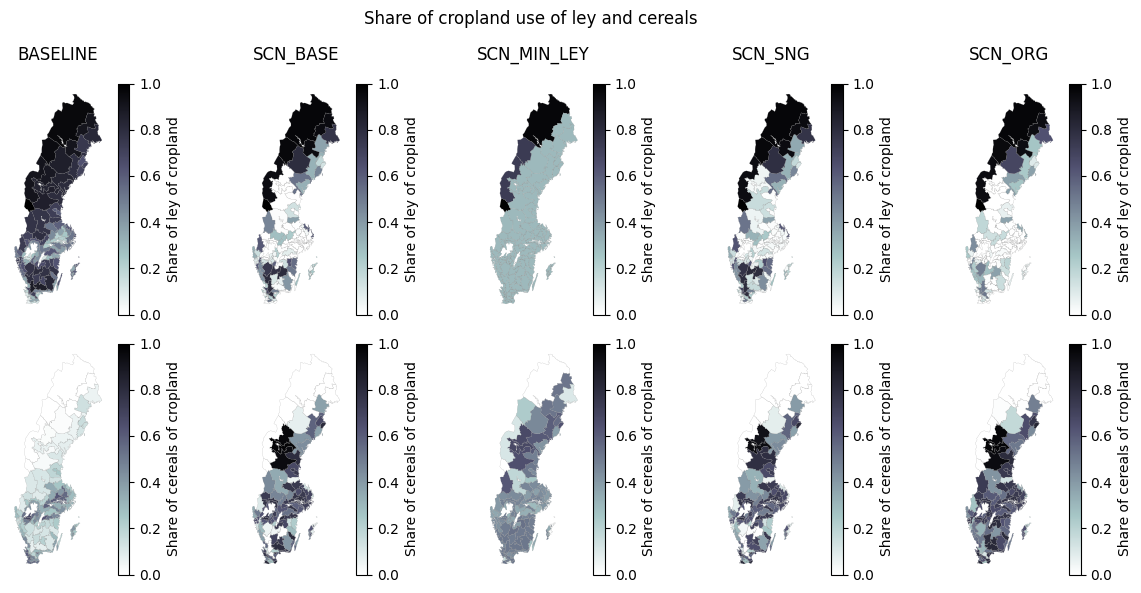

In [10]:
landuse_df = pd.concat({
    "ley": session.get_attr('C','area',groupby={'crop':'crop_group', "region": None}).droplevel("year")["Ley"],
    "cereals": session.get_attr('C','area',groupby={'crop':'crop_group', "region": None}).droplevel("year")[["Cereals, spring", "Cereals, winter"]].T.groupby("region").sum().T,
}, axis=1)
cropland_df = session.get_attr('C','area',groupby={'crop':'land_use', "region": None}).T.xs("cropland", level="land_use").T.droplevel("year")
rel_landuse_df = landuse_df/cropland_df

n_scn = len(rel_landuse_df.index)
fig, axs2d = plt.subplots(2, n_scn, figsize=(2.5*n_scn, 6))
for scn, axs in zip(rel_landuse_df.index, axs2d.T):
    axs[0].set_title(scn)
    for cg, ax in zip(["ley", "cereals"], axs):
        data = rel_landuse_df.loc[scn,(cg,slice(None))]
        ax.set_axis_off()
        plot.map_from_series(data, ax=ax, cmap="bone_r", edgecolor="grey", vmin=0, vmax=1, legend_kwds={"label": fr"Share of {cg} of cropland"})

fig.suptitle("Share of cropland use of ley and cereals")
fig.tight_layout()
#fig.savefig("figures/share-ley-cereals-of-cropland.png")
fig.show()

### Change in crops

Plots if crops increased or decarsed in amounts in each region. 

**Disabled** because it takes about 2-3 minutes to run.

### Change in total crops per region, compared to x0

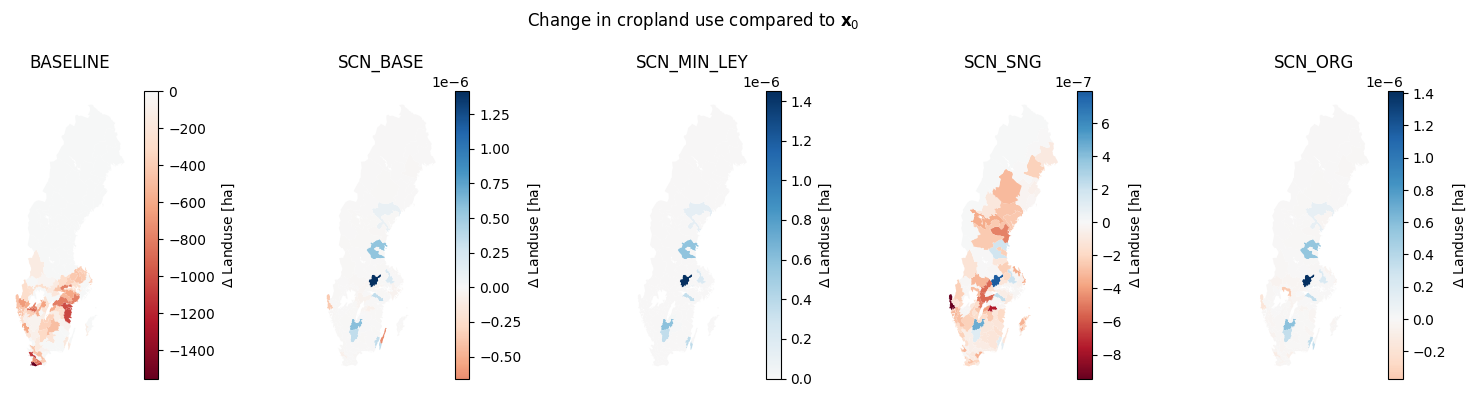

In [11]:
x0_crops_per_region = session.get_attr("r", "x0_crops", { "crop": "land_use" , "region": None, "prod_system": None })["cropland"].T.groupby(["region"]).sum().T
x_crops_per_region = session.get_attr("f", "x_crops", { "crop": "land_use", "region": None, "prod_system": None })["cropland"].T.groupby(["region"]).sum().T
delta = x_crops_per_region - x0_crops_per_region

scenarios = x0_crops_per_region.index.unique("scn")

fig, axs = plt.subplots(1, len(scenarios), figsize=(16, 4))
for scn, ax in zip(list(scenarios), axs):
    try:
        data = delta.loc[(scn, "2020"),:] 
    except Exception:
        continue
    
    ax.set_axis_off()
    ax.set_title(scn)
    plot.map_from_series(data, cmap="RdBu", ax=ax, cmap_zero_midpoint="shrink", legend_kwds={ "label": r"$\Delta$ Landuse [ha]" })

fig.suptitle(r"Change in cropland use compared to $\mathbf{x}_0$")
fig.tight_layout()

### Change in total crops per region, compared to the baseline

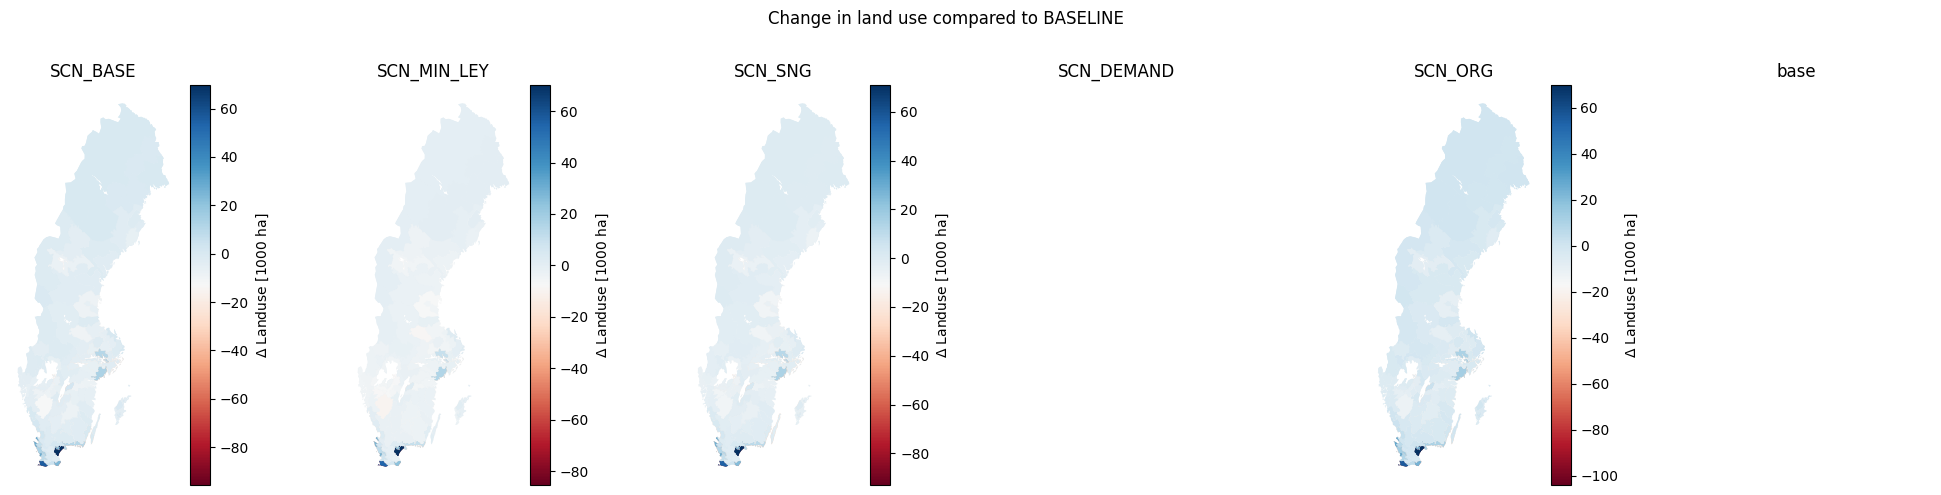

In [12]:
BL_crops_per_region = session.get_attr("r", "x0_crops", ["prod_system", "region"], scn="BASELINE").loc[("BASELINE","2020")]
SCNS_crops_per_region = session.get_attr("f", "x_crops").drop(columns=[("Wheat (add)",), ("Peas (add)",)]).T.groupby(["prod_system", "region"]).sum().T
SCNS_crops_per_region = SCNS_crops_per_region.drop([("BASELINE", "2020")])
delta = SCNS_crops_per_region - BL_crops_per_region

scenarios = [scn for scn in session.scenarios() if scn != "BASELINE"]
fig, axs = plt.subplots(1, len(scenarios), figsize=(20, 5))
for scn, ax in zip(scenarios, axs):
    ax.set_axis_off()
    ax.set_title(scn)
    
    try:
        data = delta.loc[(scn, "2020"),:] / 1e3
    except Exception:
        continue
    
    plot.map_from_series(data, cmap="RdBu", ax=ax, legend_kwds={ "label": r"$\Delta$ Landuse [1000 ha]" })

fig.suptitle("Change in land use compared to BASELINE")
fig.tight_layout()

## Byproducts

### Total use and supply of by_products

### Distribution of by product usage

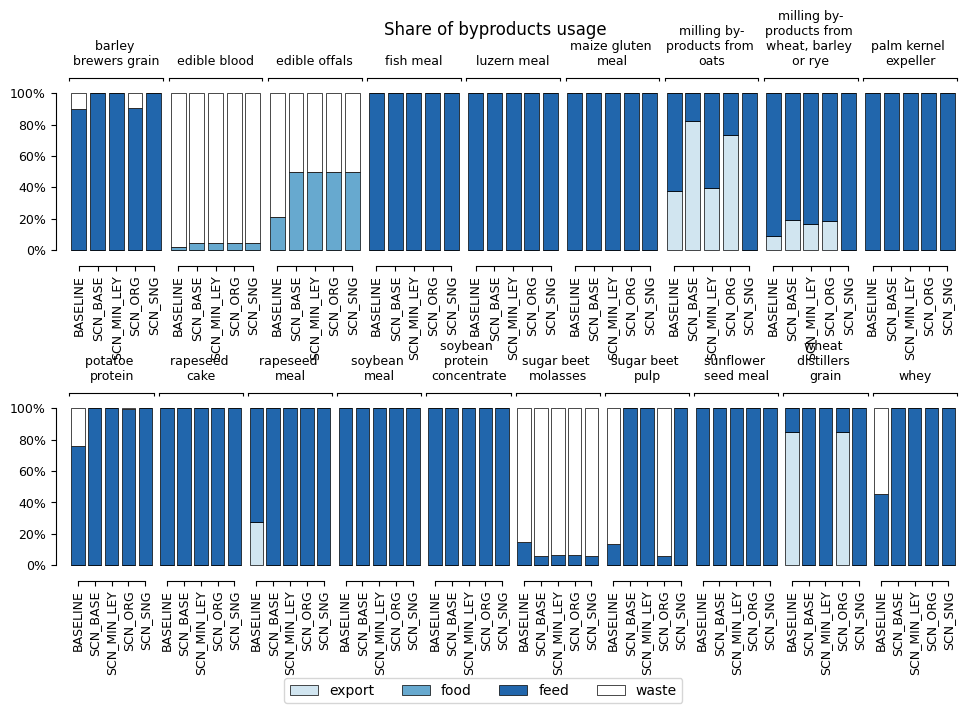

In [98]:
from matplotlib.colors import ListedColormap

AS_PERC=True

def get_use(scn: str):
    return pd.concat([
        # By product demand
        session.get_attr('D', 'by_prod_demand', ['by_prod', 'demand']).loc[(scn,"2020")].unstack(fill_value=0),
        # Feed
        session.get_attr('A', 'feed.by_product_demand', 'by_prod')
        .loc[(scn,"2020")]
        .rename('feed'),
        # Waste
        session.get_attr('D', 'by_prod_to_waste', 'by_prod').loc[(scn,"2020")]
        .rename('waste')
    ], axis=1).fillna(0).rename_axis('origin', axis=1)

plot_data = (
    pd.concat([
        pd.concat({scn: get_use(scn)}, names=['flow'], axis=1) 
        for scn in SCENARIOS
    ], axis=1)
    .stack('flow')
    .sort_index(level='flow', ascending=True)
    .sort_index(level='by_prod', sort_remaining=False)
    .fillna(0)
    / 1e6
)

plot_data = plot_data[plot_data.sum(axis=1) > 0]

if AS_PERC:
    plot_data = (plot_data.T /  plot_data.T.sum()).T
    plot_data = plot_data[plot_data.loc[:, "waste"] != 1]

colors = ['#d1e5f0', '#67a9cf', '#2166ac', '#ffffff']
cust_cmap = ListedColormap(name='X', colors=colors)

by_prods = plot_data.index.unique("by_prod").tolist()
n = int(len(by_prods) / 2)
bps_a, bps_b = by_prods[:n], by_prods[n:],

fig, axs = plt.subplots(2, 1, figsize=(10, 7))
for bps, ax in zip([bps_a, bps_b], axs):
    cm.plot.bar(
        plot_data.loc[bps],
        ax=ax,
        cmap = cust_cmap,
        group_levels='by_prod',
        sort_groups=False,
        grouplabels_vertical=False,
        group_spacing = 0.3,
        ticklabels_fontsize = 9,
        grouplabels_fontsize = 9,
        ylabel_fontsize = 10,
        xlabel_fontsize = 10,
    )

handles, labels = axs.reshape(-1)[0].get_legend_handles_labels() 
[ax.get_legend().remove() for ax in axs.reshape(-1)]
fig.legend(handles, labels, loc="lower center", ncol=4)

for ax in axs:
    if AS_PERC:
        ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1))
    else:
        ax.set_ylabel("[million kg]")

if AS_PERC:
    title = "Share of byproducts usage"
else:
    title = "Use of byproducts"
    
fig.suptitle(title)

fig.tight_layout()
fig.subplots_adjust(bottom=0.20)
fig.savefig("figures/share-of-byproducts.pdf")
fig.show()

In [14]:
cattle_numbers = session.get_attr("a", "heads", ["species", "breed"]).T.xs("cattle", level="species").T.droplevel("year")
display(cattle_numbers)
print(cattle_numbers.astype(int).to_latex().replace("_", "\\_"))

breed,beef,dairy
scn,,
BASELINE,582095.894908,841036.701513
SCN_BASE,0.000000,532307.748815
SCN_MIN_LEY,779861.339497,559548.819950
SCN_SNG,261850.833192,532307.748759
SCN_ORG,0.000000,52162.242289


\begin{tabular}{lrr}
\toprule
breed & beef & dairy \\
scn &  &  \\
\midrule
BASELINE & 582095 & 841036 \\
SCN\_BASE & 0 & 532307 \\
SCN\_MIN\_LEY & 779861 & 559548 \\
SCN\_SNG & 261850 & 532307 \\
SCN\_ORG & 0 & 52162 \\
\bottomrule
\end{tabular}



## Feed rations

### Cattle feed demand by category

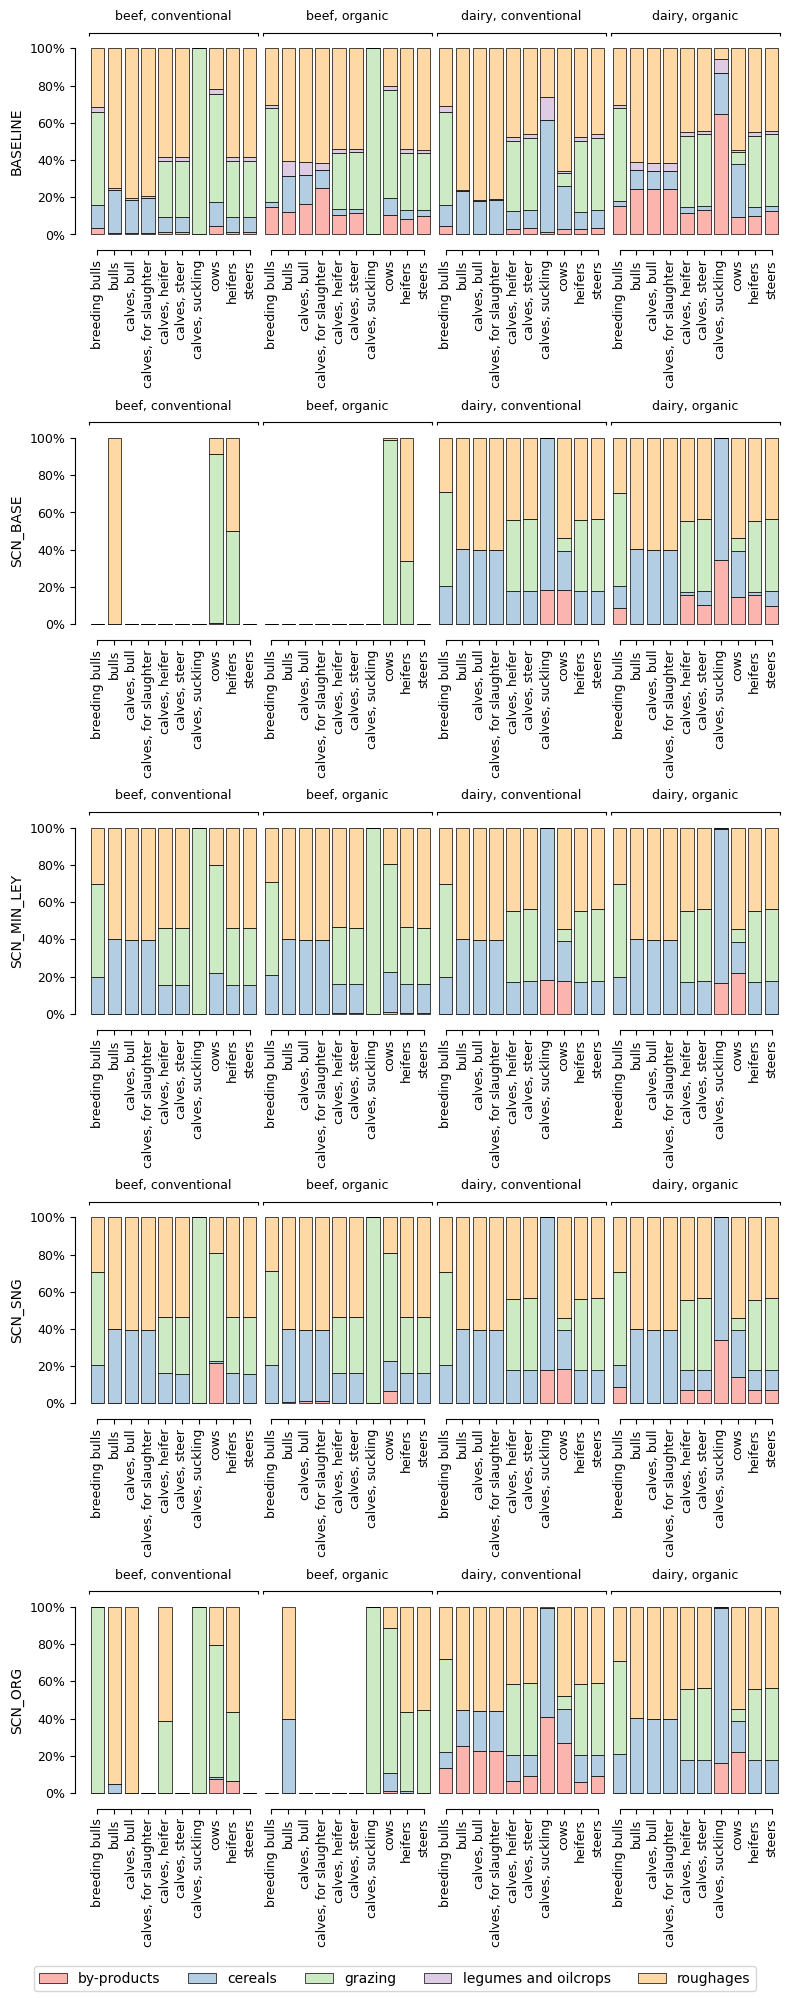

In [109]:
feed_demands = session.get_attr("A", "feed.demand", {"feed": ["feed_group2", None], "breed": None, "prod_system": None, "animal": None, "species": None}).droplevel("year").T.xs("cattle", level="species").T
feed_demands.columns = pd.MultiIndex.from_tuples(map(lambda tup: tup if not pd.isna(tup[0]) else ("by_product", *tup[1:]), feed_demands.columns.values), names=feed_demands.columns.names)
feed_demands = feed_demands.T.groupby(["feed_group2", "breed", "prod_system", "animal"]).sum().T
feed_demands_total = feed_demands.T.groupby(["breed", "prod_system", "animal"]).sum().T

fig, axs = plt.subplots(len(SCENARIOS), 1, figsize=(8, len(SCENARIOS)*4))
for scn, ax in zip(SCENARIOS, axs):
    data = (feed_demands.loc[scn].unstack("feed_group2").T / feed_demands_total.loc[scn]).T.sort_index()
    data.sort_index()
    cm.plot.bar(
        data,
        ax=ax,
        cmap = "Pastel1",
        group_levels=["breed", "prod_system"],
        sort_groups=False,  # Use the already-sorted index instead
        grouplabels_vertical=False, 
        group_spacing = 0.3,
        ticklabels_fontsize = 9,
        grouplabels_fontsize = 9,
        ylabel_fontsize = 10,
        xlabel_fontsize = 10
    )
    #if ax not in [axs[0], axs[-1]]:
    #    ax.set_xticks([])
    #ax.tick_params(
    #    axis='x',          # changes apply to the x-axis
    #    which='both',      # both major and minor ticks are affected
    #    bottom='off',      # ticks along the bottom edge are off
    #    top='off',         # ticks along the top edge are off
    #    labelbottom='off'
    #)
    ax.set_ylabel(scn)
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1))


## Remove all the subplot-legends and add a common one for the entire figure
handles, labels = axs.reshape(-1)[0].get_legend_handles_labels() 
[ax.get_legend().remove() for ax in axs.reshape(-1)]
fig.legend(handles, labels, loc="lower center", ncol=5)
    
fig.tight_layout()
fig.subplots_adjust(bottom=.1) ## Make space for the extra legend
fig.savefig("figures/feed-rations.pdf")
fig.show()

### Map over where feed is produced

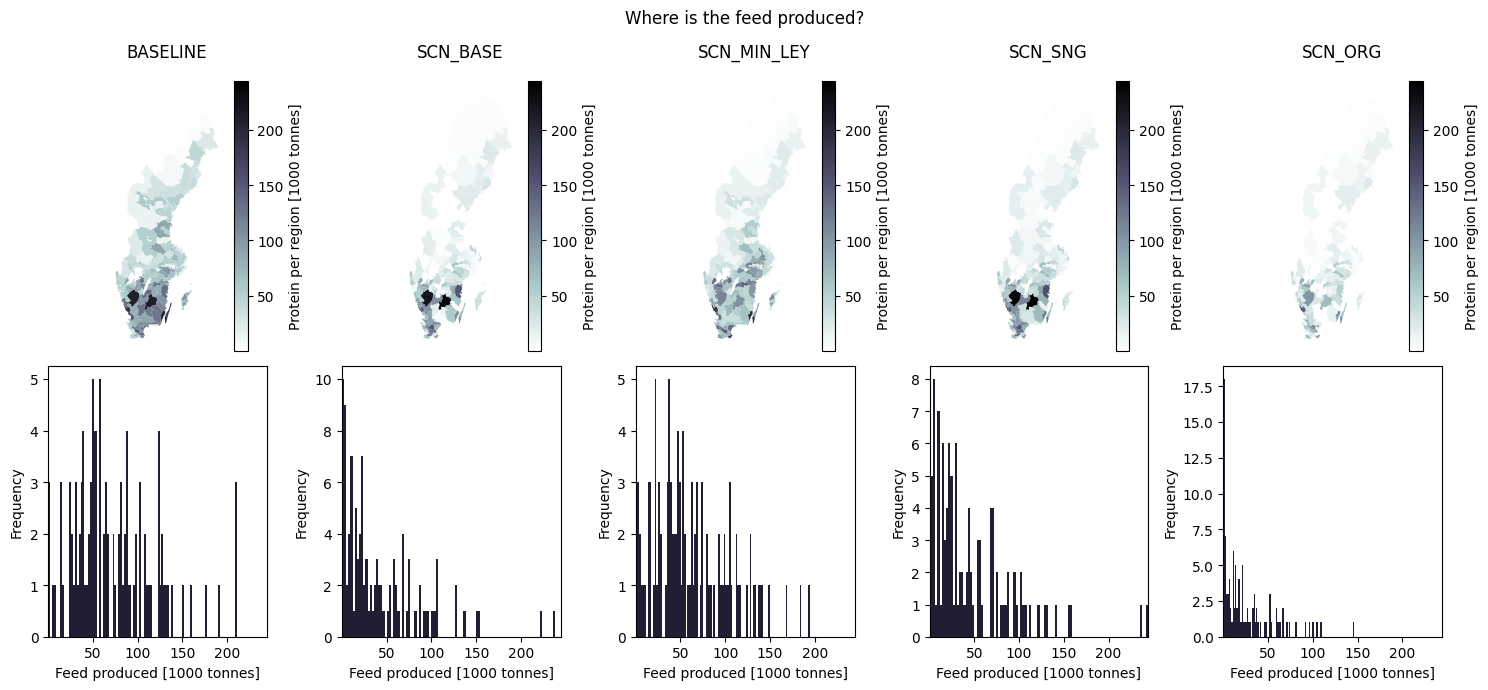

In [16]:
feed_by_region = session.get_attr("a", "feed.crop_product_demand", "region").droplevel("year").fillna(0)

feed_by_region /= 1e6

vmin, vmax = feed_by_region.min().min(), feed_by_region.max().max()
scenarios=SCENARIOS
fig, axs2d = plt.subplots(2, len(scenarios), figsize=(len(scenarios)*3, 7))

for scn, ax in zip(scenarios, axs2d[0]):
    cm.plot.map_from_series(
        feed_by_region.loc[scn], 
        ax=ax, cmap="bone_r",
        vmin=vmin, vmax=vmax, 
        legend_kwds={ "label": "Protein per region [1000 tonnes]" }
    )
    ax.set_axis_off()
    ax.set_title(scn)

for scn, ax in zip(scenarios, axs2d[1]):
    #protein_by_region.loc[scn].plot.kde(ax=ax)
    (feed_by_region.loc[scn]).plot.hist(ax=ax, bins=100, color="#201e33")
    ax.set_xlim([vmin, vmax])
    ax.set_xlabel("Feed produced [1000 tonnes]")

fig.suptitle("Where is the feed produced?")
fig.savefig("figures/feed-distribution.png")
fig.tight_layout()

## Protein production

### Bar chart: How much and which sources of protein

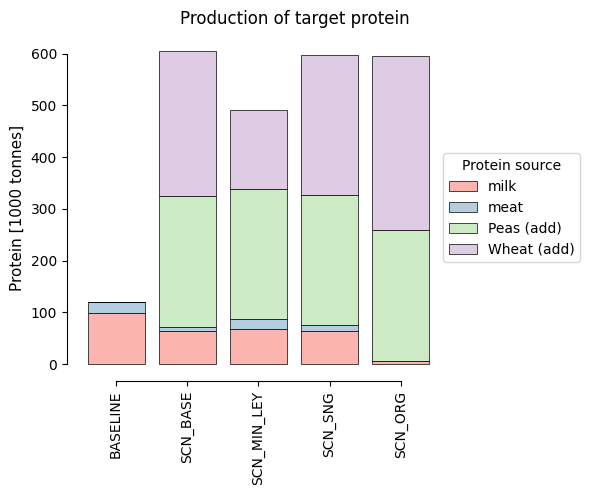

In [17]:
production = pd.concat([
    session.get_attr("a", "production").T.xs("cattle", level="species").groupby("animal_prod").sum().T[["milk", "meat"]],
    session.get_attr("c", "harvest", "crop")[["Peas (add)", "Wheat (add)"]],
], axis=1).droplevel("year").fillna(0)#.drop("BASELINE")

for prod, factor in PROTEIN_CONTENTS.items():
    production[prod] *= factor
    
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plot.bar(production / 1e9, stacked=True, ax=ax, cmap="Pastel1")
ax.set_ylabel("Protein [1000 tonnes]")
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title="Protein source")

fig.suptitle("Production of target protein")
fig.tight_layout()
fig.savefig("figures/protein-production.pdf")
fig.show()

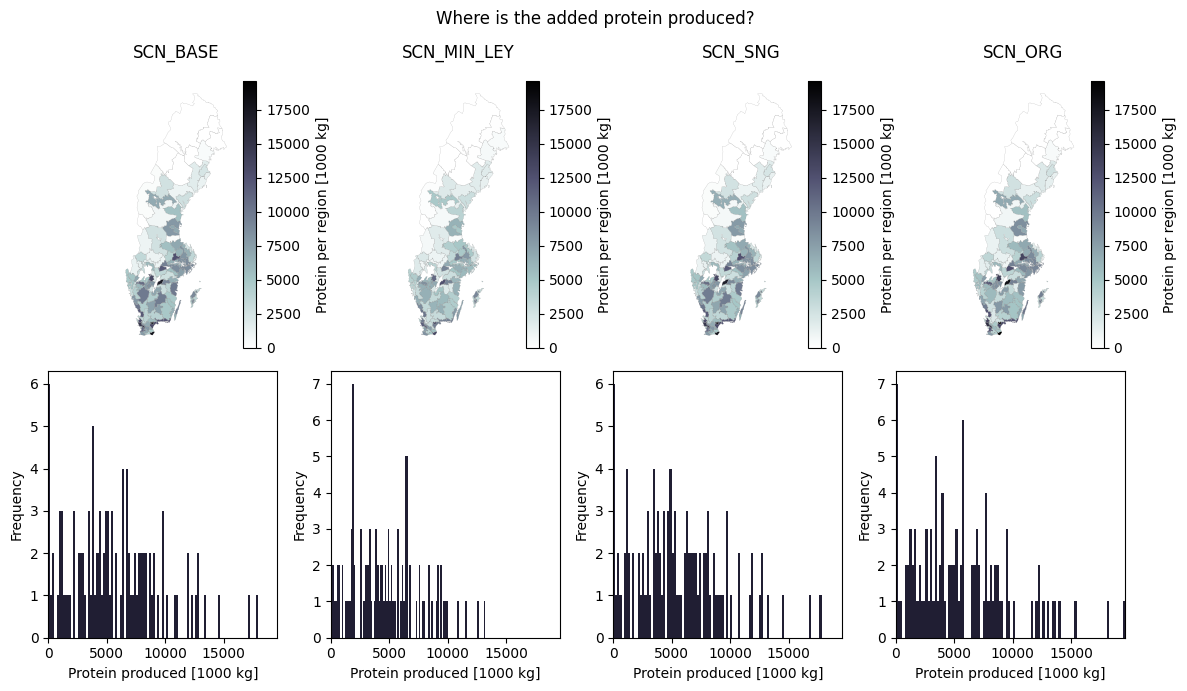

In [18]:
protein_by_region = pd.concat([
    session.get_attr("a", "production").T.xs("cattle", level="species").groupby(["animal_prod", "region"]).sum().T[["milk", "meat"]],
    session.get_attr("c", "harvest", ["crop", "region"])[["Peas (add)", "Wheat (add)"]],
], axis=1).droplevel("year").drop("BASELINE").fillna(0)

# Multiply each product by its protein contents (g protein / kg product)
for prod, factor in PROTEIN_CONTENTS.items():
    protein_by_region[prod] *= factor

# Sum across all products to get total protein amount
protein_by_region = protein_by_region.T.groupby("region").sum().T
scenarios = [scn for scn in SCENARIOS if scn != "BASELINE"]

protein_by_region /= 1e6

vmin, vmax = protein_by_region.min().min(), protein_by_region.max().max()
fig, axs2d = plt.subplots(2, len(scenarios), figsize=(len(scenarios)*3, 7))

for scn, ax in zip(scenarios, axs2d[0]):
    cm.plot.map_from_series(
        protein_by_region.loc[scn], ax=ax, 
        vmin=vmin, vmax=vmax, cmap="bone_r", edgecolor="grey",
        legend_kwds={ "label": "Protein per region [1000 kg]" }
    )
    ax.set_axis_off()
    ax.set_title(scn)

for scn, ax in zip(scenarios, axs2d[1]):
    #protein_by_region.loc[scn].plot.kde(ax=ax)
    protein_by_region.loc[scn].plot.hist(ax=ax, bins=100, color="#201e33")
    ax.set_xlim([vmin, vmax])
    ax.set_xlabel("Protein produced [1000 kg]")
    #[ax.spines[pos].set_visible(False) for pos in ["top", "right", "bottom"]]
    
fig.suptitle("Where is the added protein produced?")
fig.tight_layout()
fig.savefig("figures/protein-distribution.png")

## Chloropleth maps over added crops/meat

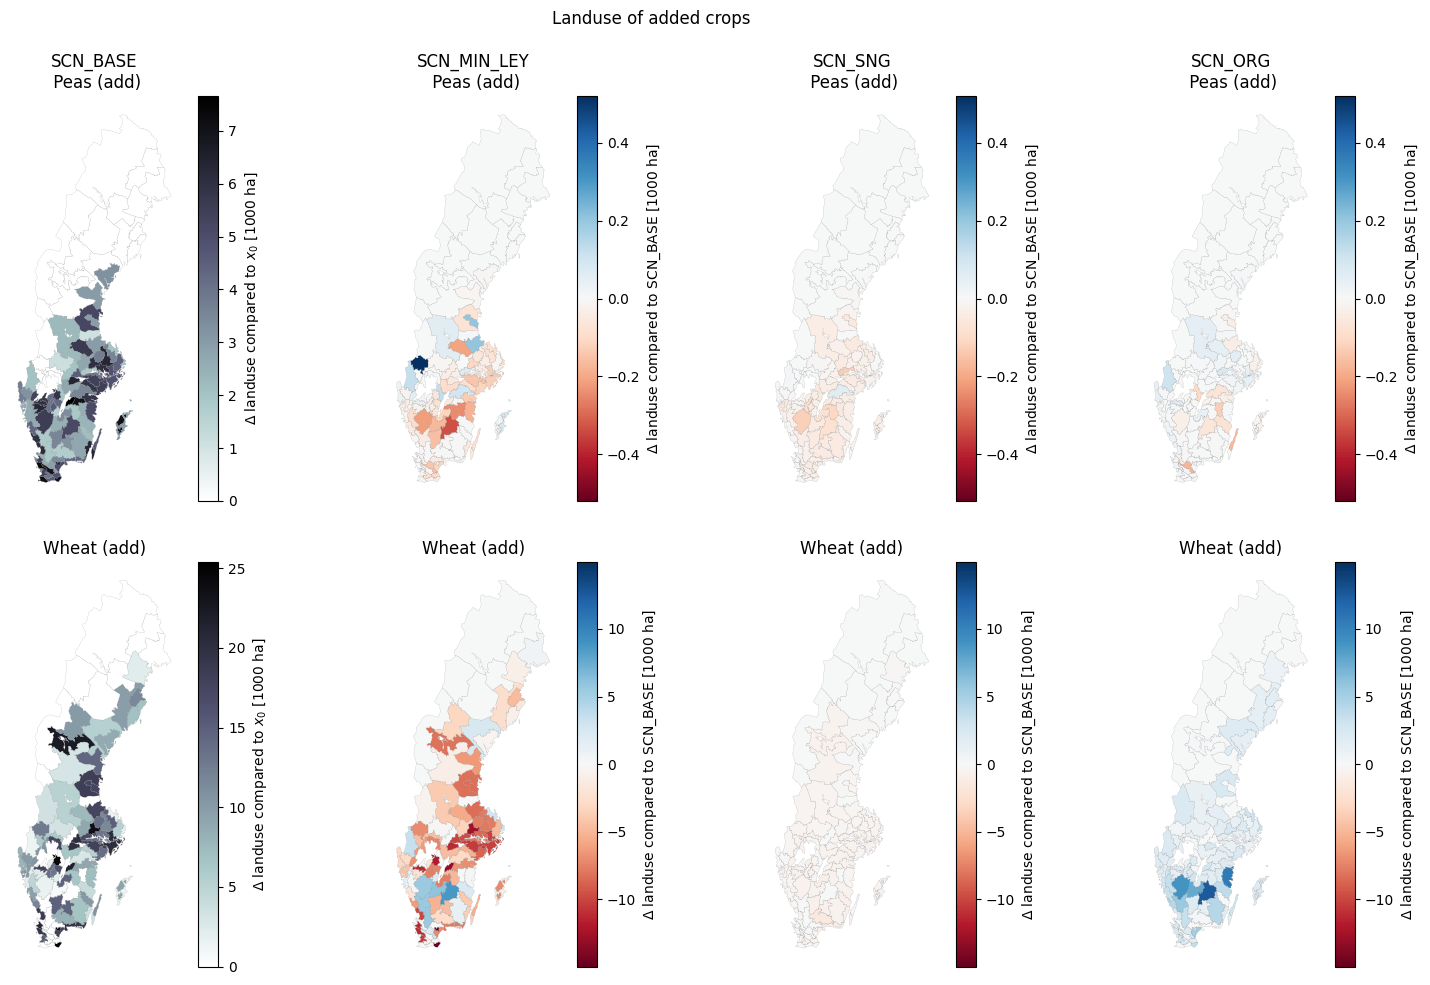

In [19]:
def get_x(crp: str):
    return session.get_attr("f", "x_crops").xs(crp, level="crop", drop_level=False, axis=1).droplevel("year")

CROPS = ["Peas (add)", "Wheat (add)"]
crops = pd.concat([get_x(crp) for crp in CROPS], axis=1).drop("BASELINE") / 1e3

nrows = len(CROPS)
ncols = crops.shape[0]
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*5))

if nrows == 1:
    axs = [axs]

vmin = { k: (crops.loc[:, (k, "conventional", )] - crops.loc["SCN_BASE",(k, "conventional", )]).min().min() for k in CROPS }
vmax = { k: (crops.loc[:, (k, "conventional", )] - crops.loc["SCN_BASE",(k, "conventional", )]).max().max() for k in CROPS }

for crp in CROPS:
    _min, _max = vmin[crp], vmax[crp]
    if _min*_max > 0:
        continue
    val = max(-_min, _max)
    vmin[crp] = -max(-_min, _max)
    vmax[crp] = max(-_min, _max) 

for scn_i, scn in enumerate(crops.index):
    for crp_i, crp in enumerate(CROPS):
        data=crops.loc[scn,(crp, "conventional",)]
        ax=axs[crp_i][scn_i]
        ax.set_axis_off()
        
        ax.set_title(crp if crp_i > 0 else f"{scn}\n {crp}")

        if scn == "SCN_BASE":
            cm.plot.map_from_series(data, ax=ax, cmap="bone_r", edgecolor="grey", legend_kwds={ "label": r"$\Delta$ landuse compared to $x_0$ [1000 ha]" })
        else:
            data = data - crops.loc["SCN_BASE", (crp, "conventional",)]
            cm.plot.map_from_series(
                data, ax=ax, 
                cmap="RdBu", edgecolor="grey", 
                vmin=vmin[crp], vmax=vmax[crp],
                legend_kwds={ "label": r"$\Delta$ landuse compared to SCN_BASE [1000 ha]" }
            )

fig.suptitle("Landuse of added crops")
fig.tight_layout()
fig.savefig("figures/landuse-added-crops.png")

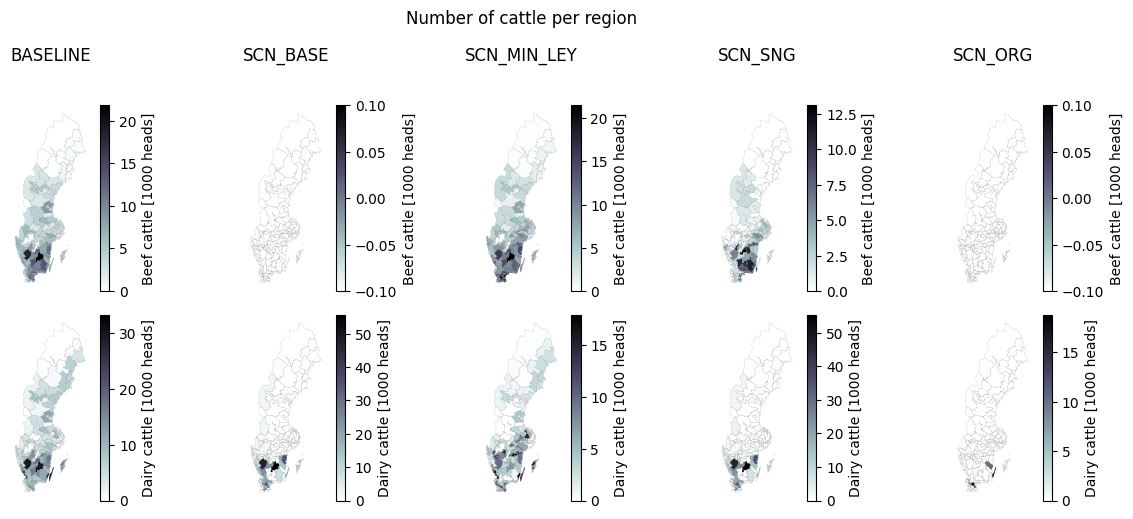

In [20]:
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import PercentFormatter

x_cattle = session.get_attr("a", "heads", ["species", "breed", "region"]).xs("cattle", level="species", axis=1).droplevel("year")

n_scn = len(x_cattle.index.values)
breeds = x_cattle.columns.unique("breed").values
fig, axes2d = plt.subplots(len(breeds), n_scn, figsize=(n_scn * 2.5, 5.25))

for scn, axs in zip(x_cattle.index, axes2d.T):
    axs[0].set_title(scn + "\n")
    for breed, ax in zip(breeds, axs):
        data = x_cattle.loc[scn, (breed,)] / 1e3
        cm.plot.map_from_series(
            data, ax=ax, 
            vmin=0, cmap="bone_r", edgecolor="grey", 
            legend_kwds={ "label": f"{breed.title()} cattle [1000 heads]" }
        )
        ax.set_axis_off()

fig.suptitle("Number of cattle per region")
fig.tight_layout()
fig.savefig("figures/cattle-distribution.png")
fig.show()

# Impacts

## Greenhouse gases

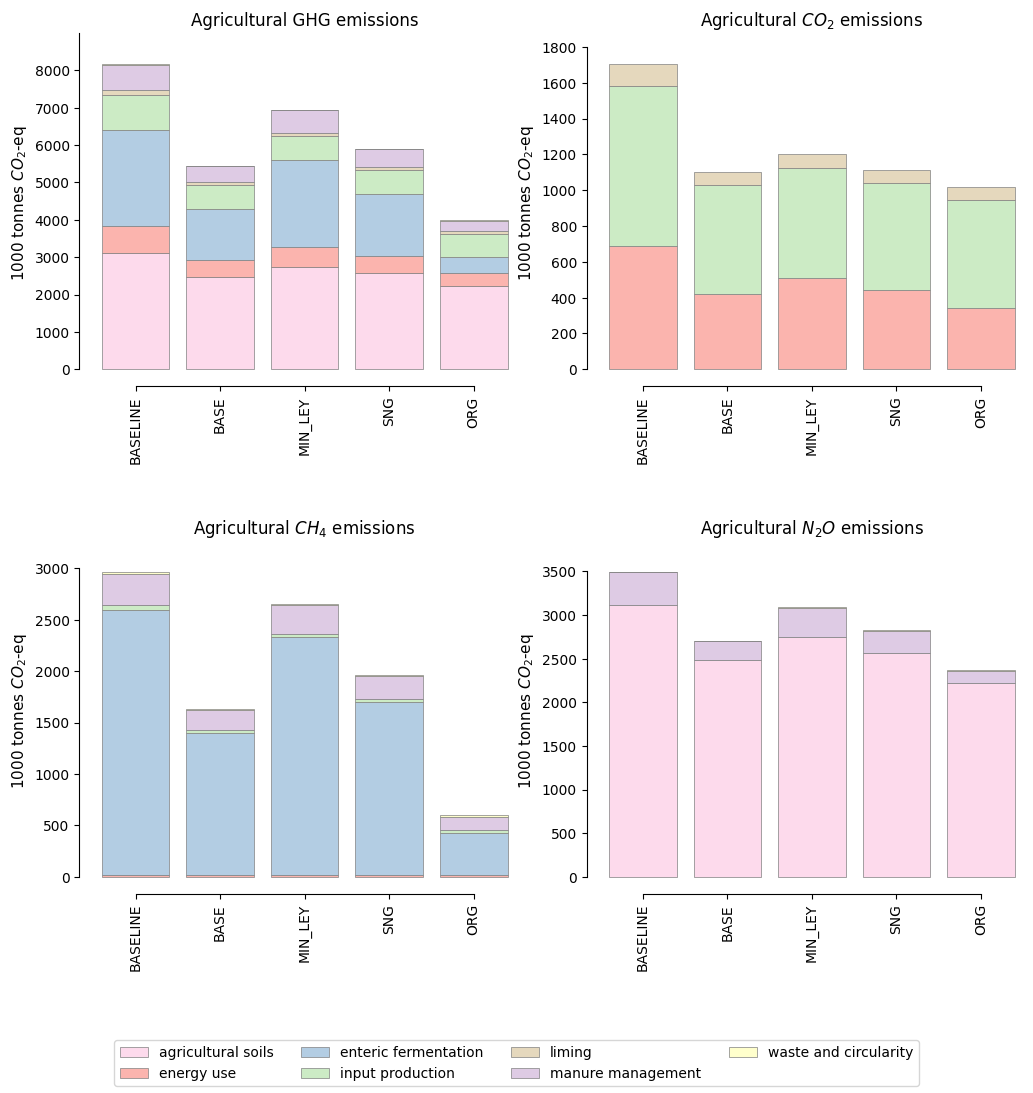

In [21]:
import matplotlib as mpl

ghg_impacts = (
    cm.impact.get_GHG(session)
    .T.groupby(['compound','process']).sum().T
    .droplevel('year')
)/1e6

def plot_ghg(
    ghgs: list[str] | str | slice,
    title: str,
    ax: plt.Axes | None = None,
    color_map: dict[str, tuple] | None = None
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,6))

    if isinstance(ghgs, str):
        ghgs = [ghgs]

    data = ghg_impacts.loc[:,ghgs].T.groupby('process').sum().T

    plot.bar(
        data=data,
        ax=ax,
        edgecolor='grey',
        cmap="Pastel1"
    )

    ax.axhline(
        y=data.sum(axis=1).loc["BASELINE"],
        xmin=0, xmax=1, zorder=0, 
        linestyle='--', linewidth=0.8, color='lightgrey'
    )

    # Manually set color of each bar to the defined color_map
    if color_map:
        n_scenarios = len(data.index)
        colors = [color_map[cat] for cat in data.columns.unique("process")]
        rects = list(
            filter(lambda x: isinstance(x, mpl.patches.Rectangle), ax.get_children())
        )
        for i, c in enumerate(colors):
            for scn_i in range(0, n_scenarios):
                rects[i * n_scenarios + scn_i].set_facecolor(c)

    ax.set_title(title)
    ax.tick_params(axis='y', which='major')
    ax.set_xlabel("")
    ax.set_ylabel(r"1000 tonnes $CO_2$-eq")
    ax.set_ylim(top=data.sum(axis=1).max()*1.1)
    ax.legend()

# Create a dict mapping category -> color so that we get consistent color-assignments across
# all subplots (e.g. 'energy use' always has the same color)
categories = ghg_impacts.columns.unique("process").values
cmap = plt.get_cmap('Pastel1', len(categories)+1)
color_map = {category: cmap(i) for i, category in enumerate(categories)}

# Draw plots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
plot_ghg(pd.IndexSlice[:], title="Agricultural GHG emissions", ax=axs[0][0], color_map=color_map)
plot_ghg("CO2", title=r"Agricultural $CO_2$ emissions", ax=axs[0][1], color_map=color_map)
plot_ghg(["CH4bio", "CH4fos"], title=r"Agricultural $CH_4$ emissions", ax=axs[1][0], color_map=color_map)
plot_ghg(["N2O", "N2Oind"], title=r"Agricultural $N_2O$ emissions", ax=axs[1][1], color_map=color_map)


# Adjust plots
# ------------

## Remove all the subplot-legends and add a common one for the entire figure
co2e_handles, co2e_labels = axs[0][0].get_legend_handles_labels() 
[ax.get_legend().remove() for ax in axs.reshape(-1)]
fig.legend(co2e_handles, co2e_labels, loc="lower center", ncol=4)

## Remove SCN_ as prefix from xtick-labels to get save space
for ax in axs.reshape(-1):
    ax.set_xticklabels([
        item.get_text().removeprefix("SCN_") 
        for item in ax.get_xticklabels()
    ])

## Control the spacing 
fig.subplots_adjust(wspace=0.2, hspace=0.5, bottom=.175)

## Mineral N use

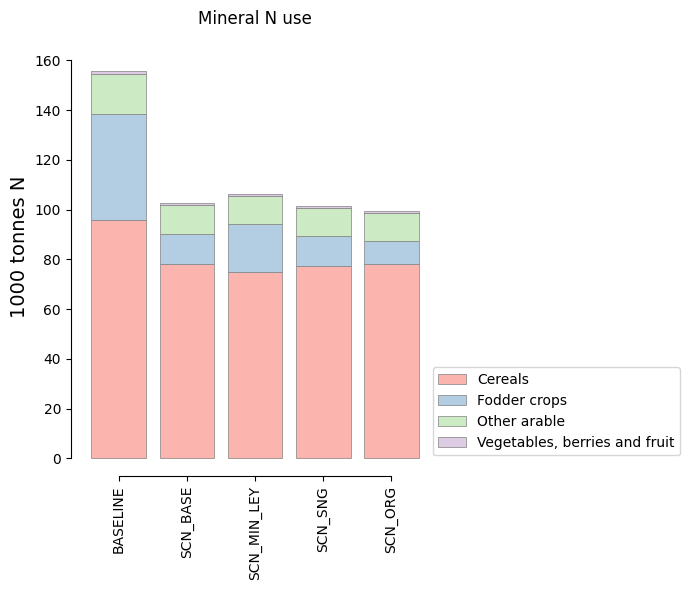

In [22]:
fig, ax = plt.subplots(figsize=(7,6))

plot_data3 = (
    (session.get_attr('C','fertiliser.mineral_N',groupby={'crop':'crop_group2'})/1000000)
    .drop(['Greenhouse crops','Semi-natural grasslands'], axis=1, errors='ignore')
    .droplevel('year')
)

plot.bar(
    data=plot_data3,
    ax=ax,
    cmap='Pastel1',
    edgecolor='grey',
)

ax.set_title('Mineral N use')
ax.tick_params(axis='y', which='major')
ax.set_xlabel('')
ax.set_ylabel('1000 tonnes N', size=14)
ax.set_ylim(top=plot_data3.sum(axis=1).max()*1.1)
ax.legend(loc='lower left', bbox_to_anchor=(1, 0))

plt.tight_layout()
plt.show()

## N and P application

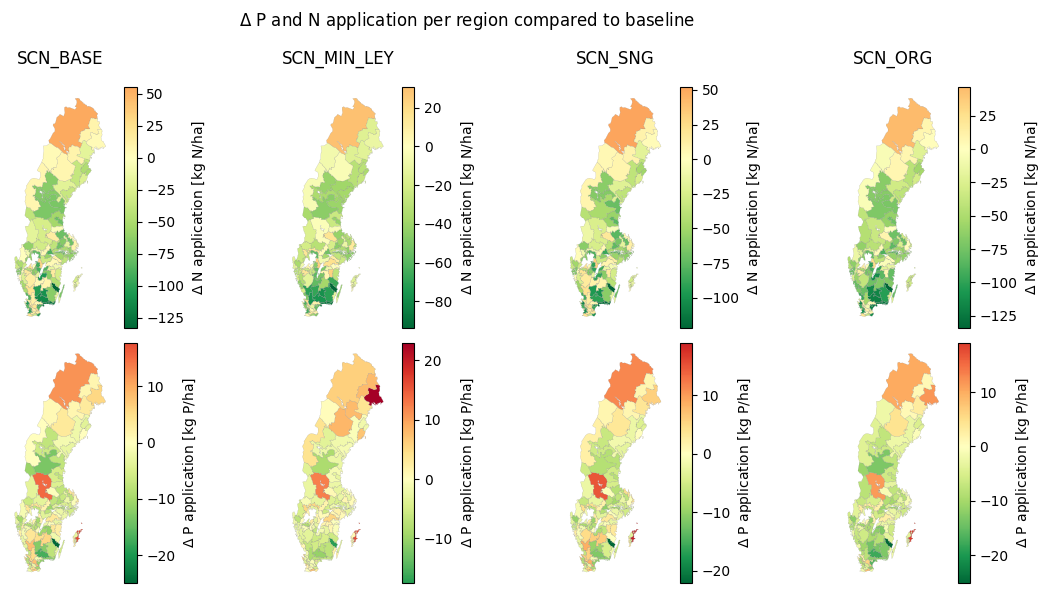

In [23]:
# CHANGES IN N AND P APPLICATION

scenarios = SCENARIOS[1:]

plot_data_N = (
    (session.get_attr('C','fertiliser.manure_N',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1)
    + session.get_attr('C','fertiliser.mineral_N',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1))
    /
    session.get_attr('C','area',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1)
).droplevel("year")
plot_data_N = (plot_data_N - plot_data_N.loc['BASELINE'])

plot_data_P = (
    (session.get_attr('C','fertiliser.manure_P',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1)
    + session.get_attr('C','fertiliser.mineral_P',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1))
    /
    session.get_attr('C','area',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1)
).droplevel("year")
plot_data_P = (plot_data_P - plot_data_P.loc['BASELINE'])

fig, axs2d = plt.subplots(2, len(scenarios), figsize=(3*(len(scenarios)), 6))

styles = { 
    "cmap": "RdYlGn_r",
    "cmap_zero_midpoint": "shrink",
    "edgecolor": "grey"
}

for scn, axs in zip(scenarios, axs2d.T):   
    for map_data, ax, label in [
        (plot_data_N.loc[scn], axs[0], r'$\Delta$ N application [kg N/ha]'),
        (plot_data_P.loc[scn], axs[1], r'$\Delta$ P application [kg P/ha]'),
    ]:
        lim = abs(map_data).quantile(0.99)
        plot.map_from_series(map_data, ax=ax, legend_kwds={'label': label}, **styles)
        ax.axis('off')

    axs[0].set_title(scn)
    
fig.suptitle(r"$\Delta$ P and N application per region compared to baseline")
fig.tight_layout()

## Diversity in crops (**not** overall biodiversity)

KeyError: 'SCN_DEMAND'

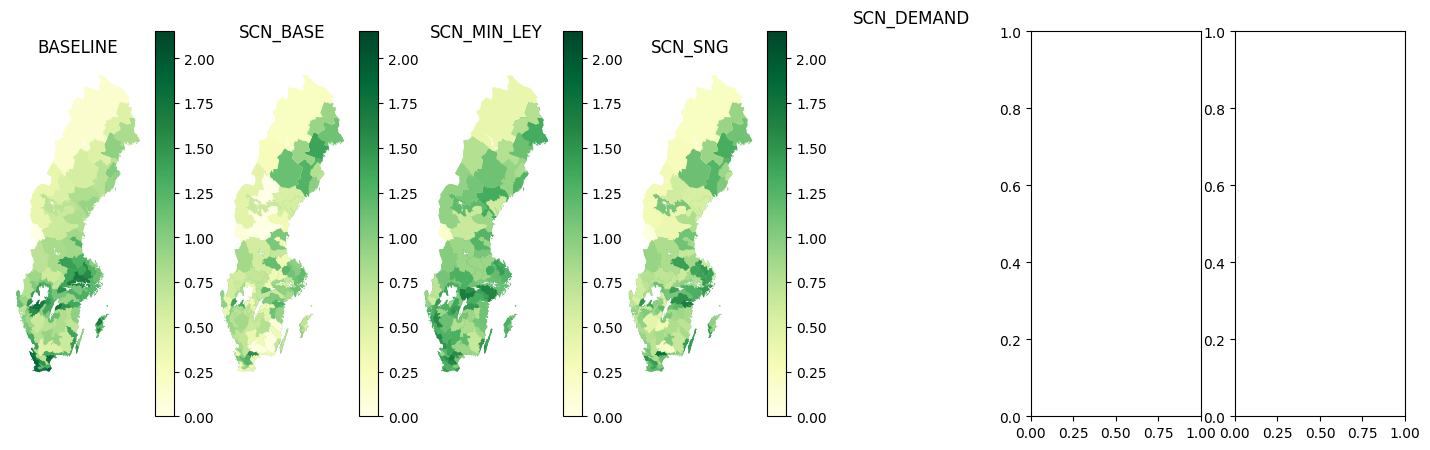

In [24]:
biodiv_data = cm.impact.biodiv.get_crop_div(session).droplevel("year")

fig, axs = plt.subplots(1, len(session.scenarios()), figsize=(18, 5))
vmax=biodiv_data.max().max()

for scn, ax in zip(list(session.scenarios().keys()), axs):
    ax.set_axis_off()
    ax.set_title(scn)
    plot.map_from_series(biodiv_data.loc[(scn),:], cmap="YlGn", ax=ax, vmin=0, vmax=vmax)#, legend_kwds={"label": "Biodiversity index"})

fig.suptitle("Crop diversity values [Shannon's index]")
fig.tight_layout()

## Share of organic land-use

In [ ]:
total_prod = session.get_attr("c", "area", ["region"]).droplevel("year")
organic_prod = session.get_attr("c", "area", ["prod_system", "region"]).droplevel("year").loc[:, ("organic", )]
organic_share = (organic_prod / total_prod).replace({ np.inf: 0, -np.inf: 0, np.nan: 0 })

scenarios = [s for s in session.scenarios()]
n_scn = len(scenarios)
fig, axs = plt.subplots(1, len(scenarios), figsize=(n_scn*3, 5))

for scn, ax in zip(scenarios, axs):
    plot.map_from_series(
        organic_share.loc[scn],
        ax=ax,
        vmin=0,
        vmax=1,
        edgecolor="grey",
        cmap="YlGn"
    )
    ax.set_title(scn)
    ax.set_axis_off()

fig.suptitle("Share of organic land-use")
fig.tight_layout()